In [37]:
import pandas as pd

In [38]:
df = pd.read_csv("../jigsaw/dataset_text_target.csv")
df_true = df[df.target > 0.5]
df_false = df[df.target <= 0.5]

In [39]:
df_true

,comment_text,target
4,haha you guys are a bunch of losers.,0.893617
5,ur a sh*tty comment.,0.666667
13,It's ridiculous that these guys are being call...,0.600000
31,Yet call out all Muslims for the acts of a few...,0.912500
34,This bitch is nuts. Who would read a book by a...,0.830769
...,...,...
1804786,A sexual predator lives in the White House now...,0.600000
1804825,Who is the jerk in the last row between the C ...,0.833333
1804838,Nobody really cares that she supports the scie...,0.700000
1804857,"I take your point, but I think you're shooting...",0.700000


In [40]:
DATASET_SIZE = 10_000

In [41]:
df = pd.concat([df_true[:DATASET_SIZE//2], df_false[:DATASET_SIZE//2]], axis=0)

<Axes: >

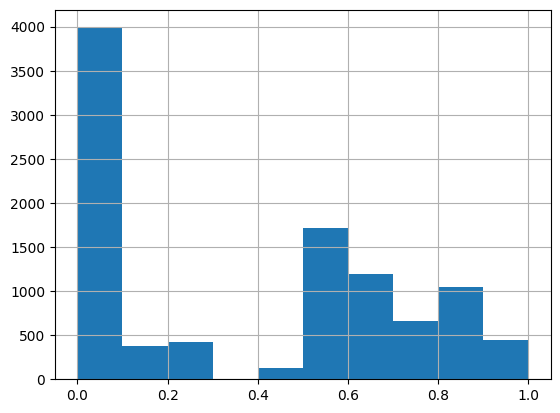

In [42]:
df.target.hist()

In [43]:
mapper = lambda x: 1 if x > 0.5 else 0
df.target = df.target.apply(mapper)

In [44]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.comment_text, df.target, test_size=0.2, random_state=42, stratify=df.target, shuffle=True)

In [46]:
y_train.value_counts()

target
0    4000
1    4000
Name: count, dtype: int64

In [47]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [48]:
max_len = 128

In [49]:
X_train_encoded = tokenizer.batch_encode_plus(
    x_train.tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_len,
    add_special_tokens=True,
    return_tensors='tf'
)
X_test_encoded = tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_len,
    add_special_tokens=True,
    return_tensors='tf'
)

In [13]:
model = TFBertForSequenceClassification.from_pretrained('../bert_model_trained', num_labels=2)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../bert_model_trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [50]:
y_test.value_counts()

target
0    1000
1    1000
Name: count, dtype: int64

In [15]:
from sklearn.metrics import classification_report

In [51]:
import tensorflow as tf
y_pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
y_pred = tf.argmax(y_pred.logits, axis=1).numpy()


63/63 [==============================] - 77s 1s/step


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1000
           1       0.99      0.94      0.96      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [53]:
sentences = x_test.tolist()
predicted = y_pred.tolist()
truth = y_test.tolist()
size = len(sentences)

mismatches = []
for i in range(size):
    if predicted[i] == truth[i]:
        continue
    mismatches.append((sentences[i], predicted[i], truth[i]))

In [57]:
mismatches[0]

("Well that's not very inclusive of Women's bathrooms!  The President should decree that all Women's Restrooms receive urinals so as to be more inclusive for the gender confused who just happen to have a penis.",
 0,
 1)

In [54]:
import pandas as pd
errors = pd.DataFrame(mismatches, columns=['sentence', 'predicted', 'truth'])

In [56]:
errors.to_csv("errors.csv", index=False)